In [16]:
import xarray as xr
import numpy as np
import sys
import matplotlib.pyplot as plt
import cmocean
sys.path.append('src')
# from src.dataloaders import *
# sys.path.append('/nobackup/samart18/modulus')
# from modulus.utils.generative import InfiniteSampler
data_dir = '/dat1/smart1n/ml_side_projects/GenDA_pleiades/input_data/'
ds = xr.open_dataset(data_dir + 'cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_70.00W-40.00W_25.00N-45.00N_0.49m_2010-01-01-2020-12-31_wERA5_winds_and_geostrophy_15m_ekman_regression.nc')
ds_m = xr.open_dataset(data_dir + 'glorys_gulfstream_means_wERA5_winds_and_geostrophy_15m_ekman_regression.nc')
ds_clim = xr.open_dataset(data_dir + 'glorys_gulfstream_climatology.nc')

var_stds = {'zos':float((ds['zos']-ds_m['zos']).std()), 
            'thetao':float((ds['thetao'].groupby('time.month')-ds_clim['thetao']).std()), 
            'so':float((ds['so'].groupby('time.month')-ds_clim['so']).std()), 
            'u_ageo_eddy':float((ds['u_ageo_eddy']-ds_m['u_ageo_eddy']).std()), 
            'v_ageo_eddy':float((ds['v_ageo_eddy']-ds_m['v_ageo_eddy']).std()), 
            'uas':float((ds['uas']-ds_m['uas']).std()), 
            'vas':float((ds['vas']-ds_m['vas']).std())}

variables_in = ['zos', 'thetao', 'uas', 'vas']
variables_oi = ['ssh_oi', 'sst_oi', 'sss_oi']
variables_out = ['zos','thetao','so','u_ageo_eddy', 'v_ageo_eddy']




In [7]:
lon_min = -65
lon_max = -55
lat_min = 33
lat_max = 43
time_min = np.datetime64('2017-01-01')
time_max = np.datetime64('2017-12-31')

NN_res = 1/12
NN_input_size = 128

buffer_lon = int((NN_input_size - abs(lon_max - lon_min) / NN_res) / 2)
buffer_lat = int((NN_input_size - abs(lat_max - lat_min) / NN_res) / 2)

lon_min_NN, lon_max_NN = lon_min - buffer_lon * NN_res, lon_max + buffer_lon * NN_res
lat_min_NN, lat_max_NN = lat_min - buffer_lat * NN_res, lat_max + buffer_lat * NN_res

test_dataset = L3obs_plus_L4OI_Regression_OSSE(data_dir = '/dat1/smart1n/ml_side_projects/GenDA_pleiades/input_data/', 
                       lon_min = lon_min_NN, 
                       lon_max = lon_max_NN - NN_res,
                       lat_min = lat_min_NN, 
                       lat_max = lat_max_NN - NN_res,
                       input_dim = (128, 128),
                       date_range = [date(2017,1,1),date(2017,12,31)], 
                       variables_in = ['zos', 'thetao', 'uas', 'vas'],
                       variables_out = ['zos', 'thetao', 'so', 'u_ageo_eddy', 'v_ageo_eddy', 'uas', 'vas'],
                       variables_oi = ['ssh_oi', 'sst_oi', 'sss_oi'],                
                       var_stds = var_stds, 
                       multiprocessing = False,
                       add_obs_noise=True,
                       noise_attenuation_factor = 0.2 
                        )

NameError: name 'L3obs_plus_L4OI_Regression_OSSE' is not defined

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(DownsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(F.relu(self.bn(self.conv(x))))

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(F.relu(self.bn(self.conv(x))))

class UNet_large(nn.Module):
    def __init__(self, in_channels=7, out_channels=5, dropout_rate=0.2):
        super(UNet_large, self).__init__()
        
        # Encoder
        self.down1 = DownsampleBlock(in_channels, 32, dropout_rate)
        self.down2 = DownsampleBlock(32, 64, dropout_rate)
        self.down3 = DownsampleBlock(64, 128, dropout_rate)
        self.down4 = DownsampleBlock(128, 256, dropout_rate)

        self.res1 = ResBlock(256, 256, dropout_rate)
        self.res2 = ResBlock(256, 256, dropout_rate)
        
        # Decoder
        self.up1 = UpsampleBlock(256, 128, dropout_rate)
        self.up2 = UpsampleBlock(256, 64, dropout_rate)
        self.up3 = UpsampleBlock(128,32, dropout_rate)
        self.up4 = UpsampleBlock(64, 32, dropout_rate)
        
        # Final convolution
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        # Self-attention
        # sa = self.self_attention(d4)
        
        # Residual blocks
        r = self.res1(d4)
        r = self.res2(r)
        
        # Decoder
        u1 = self.up1(r)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        u4 = self.up4(u3)
        
        # Final convolution
        output = self.final_conv(u4)
        
        return output


device = torch.device('cuda:1')
model = UNet_large().to(device)
checkpoint = torch.load('unet_checkpoints/UNet_l3l4regression_wSWOT_wnoise_oi_ssh25_sst16_sss16_epoch99.pt', map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
batch_size = 32
dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [5]:
preds = []
truth = []
count = 0
model.eval()
for x,y in dataloader:
    print(count)
    pred = model(x.to(device)).detach().cpu().numpy()
    preds.append(pred)
    truth.append(y.detach().numpy())
    count+=batch_size
preds = np.concatenate(preds, axis = 0)
truth = np.concatenate(truth, axis = 0)

0
32
64
96
128
160
192
224
256
288
320
352


/nobackup/samart18/.conda/envs/GenDA/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [6]:
ssh_unet = preds[:,0,].copy()
sst_unet = preds[:,1,].copy()
sss_unet = preds[:,2,].copy()
u_unet = preds[:,3,].copy()
v_unet = preds[:,4,].copy()

In [18]:
import cmocean

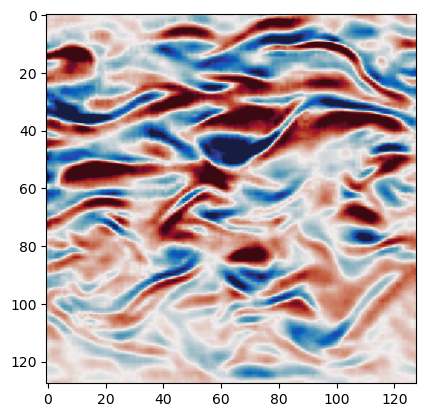

In [39]:
plt.imshow(np.flipud(u_unet[187,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

In [13]:
ds_masks = xr.open_dataset('/dat1/smart1n/ml_side_projects/GenDA_pleiades/input_data/obs_masks_ssh-sst-u-v.nc')
ds_masks['ssh_mask'] = (ds_masks['ssh_nadir'].astype('bool')) | (ds_masks['ssh_karin'].astype('bool'))
ds_oi = xr.open_dataset('/dat1/smart1n/ml_side_projects/GenDA_pleiades/input_data/oi_l4_ssh-sst-sss_updated_with_errors_sigmas_ssh25_sst16_sss16.nc')

pred_dir = 'predictions/batch64_songunet_vanilla_ema_osse_wnoise_attenuation0.2/'
data = np.zeros((365,24,5,128,128))
for t in range(365):
    # _, x_star = test_dataset.__getitem__(t)
    # x_star = x_star.unsqueeze(0).numpy()
    
    total_mask = np.stack((ds_masks['ssh_mask'].isel(time = t), 
                           ds_masks['sst_mask'].isel(time = t), 
                           np.zeros((128,128)),
                           np.zeros((128,128)),
                           np.zeros((128,128))
                          ), axis = 0)

    # plotting:
    oi_ground_truth = np.expand_dims(np.stack((ds_oi['ssh_oi'].isel(time = t),
                               ds_oi['sst_oi'].isel(time = t),
                               ds_oi['sss_oi'].isel(time = t)), axis = 0), axis = 0)

    preds = np.load(pred_dir + f'pred{t}.npy')
    
    # data[t,0,] = x_star[0,:5,]
    # data[t,1,] = x_star[0,:5,]*total_mask
    # data[t,2,:3,] = oi_ground_truth
    data[t,] = preds[:,:5,]

    
    

In [14]:
ssh_genda_mean = np.mean(data[:-1, 3:, 0,], axis = 1)
sst_genda_mean = np.mean(data[:-1, 3:, 1,], axis = 1)
sss_genda_mean = np.mean(data[:-1, 3:, 2,], axis = 1)
u_genda_mean = np.mean(data[:-1, 3:, 3,], axis = 1)
v_genda_mean = np.mean(data[:-1, 3:, 4,], axis = 1)

ssh_genda_member = data[:-1, 3, 0,].copy()
sst_genda_member = data[:-1, 3, 1,].copy()
sss_genda_member = data[:-1, 3, 2,].copy()
u_genda_member = data[:-1, 3, 3,].copy()
v_genda_member = data[:-1, 3, 4,].copy()

# ssh_true = truth[:,0,].copy()
# sst_true = truth[:,1,].copy()
# sss_true = truth[:,2,].copy()
# u_true = truth[:,3,].copy()
# v_true = truth[:,4,].copy()

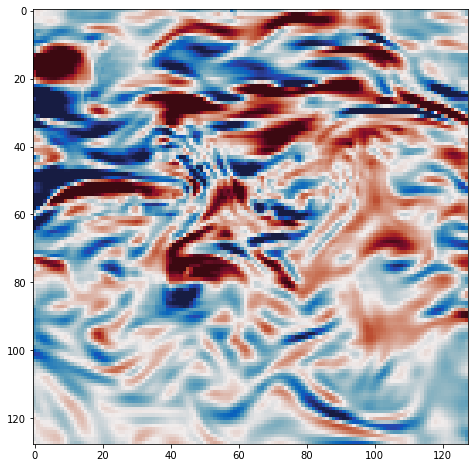

In [27]:
plt.figure(figsize = (8,8))
plt.imshow(np.flipud(u_genda_member[187,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

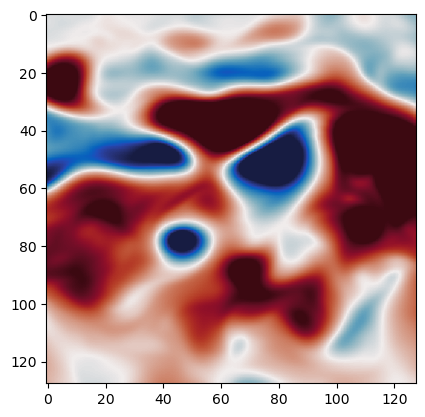

In [54]:
plt.imshow(np.flipud(ssh_true[187,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

In [28]:
from src.metrics import *

In [29]:
ssh_mask = ds_masks['ssh_mask'].values[:-1,].astype('bool')
sst_mask = ds_masks['sst_mask'].values[:-1,].astype('bool')
# ssh_mask = ~ssh_mask
# sst_mask = ~sst_mask

In [30]:
ssh_true = ssh_genda_mean.copy()
sst_true = sst_genda_mean.copy()
sss_true = sss_genda_mean.copy()
u_true = u_genda_mean.copy()
v_true = v_genda_mean.copy()


In [91]:
jsd_unet_ssh, x_grid, ssh_true_pdf, ssh_pred_unet_pdf = calculate_jsd(ssh_unet[~ssh_mask], ssh_true[~ssh_mask])
jsd_unet_sst, x_grid, sst_true_pdf, sst_pred_unet_pdf = calculate_jsd(sst_unet[~sst_mask], sst_true[~sst_mask])
jsd_unet_sss, x_grid, sss_true_pdf, sss_pred_unet_pdf = calculate_jsd(sss_unet, sss_true)
jsd_unet_u, x_grid, u_true_pdf, u_pred_unet_pdf = calculate_jsd(u_unet, u_true)
jsd_unet_v, x_grid, v_true_pdf, v_pred_unet_pdf = calculate_jsd(v_unet, v_true)

In [31]:
jsd_genda_mean_ssh, x_grid, ssh_true_pdf, ssh_pred_genda_mean_pdf = calculate_jsd(ssh_genda_mean[~ssh_mask], ssh_true[~ssh_mask])
jsd_genda_mean_sst, x_grid, sst_true_pdf, sst_pred_genda_mean_pdf = calculate_jsd(sst_genda_mean[~sst_mask], sst_true[~sst_mask])
jsd_genda_mean_sss, x_grid, sss_true_pdf, sss_pred_genda_mean_pdf = calculate_jsd(sss_genda_mean, sss_true)
jsd_genda_mean_u, x_grid, u_true_pdf, u_pred_genda_mean_pdf = calculate_jsd(u_genda_mean, u_true)
jsd_genda_mean_v, x_grid, v_true_pdf, v_pred_genda_mean_pdf = calculate_jsd(v_genda_mean, v_true)

In [93]:
jsd_genda_member_ssh, x_grid, ssh_true_pdf, ssh_pred_genda_member_pdf = calculate_jsd(ssh_genda_member[~ssh_mask], ssh_true[~ssh_mask])
jsd_genda_member_sst, x_grid, sst_true_pdf, sst_pred_genda_member_pdf = calculate_jsd(sst_genda_member[~sst_mask], sst_true[~sst_mask])
jsd_genda_member_sss, x_grid, sss_true_pdf, sss_pred_genda_member_pdf = calculate_jsd(sss_genda_member, sss_true)
jsd_genda_member_u, x_grid, u_true_pdf, u_pred_genda_member_pdf = calculate_jsd(u_genda_member, u_true)
jsd_genda_member_v, x_grid, v_true_pdf, v_pred_genda_member_pdf = calculate_jsd(v_genda_member, v_true)

In [94]:
print('SSH JSDs \n UNet:', 
      jsd_unet_ssh/1e-3, 
      '\n GenDA (ensemble mean):', 
      jsd_genda_mean_ssh/1e-3,
     '\n GenDA (ensemble member):',
     jsd_genda_member_ssh/1e-3)

print('SST JSDs \n UNet:', 
      jsd_unet_sst/1e-3, 
      '\n GenDA (ensemble mean):', 
      jsd_genda_mean_sst/1e-3,
     '\n GenDA (ensemble member):',
     jsd_genda_member_sst/1e-3,)

print('SSS JSDs \n UNet:', 
      jsd_unet_sss/1e-3, 
      '\n GenDA (ensemble mean):', 
      jsd_genda_mean_sss/1e-3,
     '\n GenDA (ensemble member):',
     jsd_genda_member_sss/1e-3,)

print('u JSDs \n UNet:', 
      jsd_unet_u/1e-3, 
      '\n GenDA (ensemble mean):', 
      jsd_genda_mean_u/1e-3,
     '\n GenDA (ensemble member):',
     jsd_genda_member_u/1e-3,)

print('v JSDs \n UNet:', 
      jsd_unet_v/1e-3, 
      '\n GenDA (ensemble mean):', 
      jsd_genda_mean_v/1e-3,
     '\n GenDA (ensemble member):',
     jsd_genda_member_v/1e-3,)


SSH JSDs 
 UNet: 0.06676421997368562 
 GenDA (ensemble mean): 0.14967287714411673 
 GenDA (ensemble member): 0.18855739293053012
SST JSDs 
 UNet: 1.4829694295126499 
 GenDA (ensemble mean): 6.945945717862265 
 GenDA (ensemble member): 7.5937434004097835
SSS JSDs 
 UNet: 0.2324572394938934 
 GenDA (ensemble mean): 3.6810582893797896 
 GenDA (ensemble member): 3.919746848237776
u JSDs 
 UNet: 9.297050163694482 
 GenDA (ensemble mean): 52.05930471078531 
 GenDA (ensemble member): 0.901935261928352
v JSDs 
 UNet: 9.299631661146366 
 GenDA (ensemble mean): 70.5329907426144 
 GenDA (ensemble member): 4.568413039367348


In [117]:
crop = 8

In [120]:
ssh_unet_r2 = calculate_R2(ssh_unet[~ssh_mask], ssh_true[~ssh_mask])
sst_unet_r2 = calculate_R2(sst_unet[~sst_mask], sst_true[~sst_mask])
sss_unet_r2 = calculate_R2(sss_unet, sss_true)
u_unet_r2 = calculate_R2(u_unet, u_true)
v_unet_r2 = calculate_R2(v_unet, v_true)

ssh_genda_mean_r2 = calculate_R2(ssh_genda_mean[~ssh_mask], ssh_true[~ssh_mask])
sst_genda_mean_r2 = calculate_R2(sst_genda_mean[~sst_mask], sst_true[~sst_mask])
sss_genda_mean_r2 = calculate_R2(sss_genda_mean, sss_true)
u_genda_mean_r2 = calculate_R2(u_genda_mean, u_true)
v_genda_mean_r2 = calculate_R2(v_genda_mean, v_true)

ssh_genda_member_r2 = calculate_R2(ssh_genda_member[~ssh_mask], ssh_true[~ssh_mask])
sst_genda_member_r2 = calculate_R2(sst_genda_member[~sst_mask], sst_true[~sst_mask])
sss_genda_member_r2 = calculate_R2(sss_genda_member, sss_true)
u_genda_member_r2 = calculate_R2(u_genda_member, u_true)
v_genda_member_r2 = calculate_R2(v_genda_member, v_true)

In [121]:
print('SSH R2s \n UNet:', 
      ssh_unet_r2, 
      '\n GenDA (ensemble mean):', 
      ssh_genda_mean_r2,
      '\n GenDA (ensemble member):',
      ssh_genda_member_r2)

print('SST R2s \n UNet:', 
      sst_unet_r2, 
      '\n GenDA (ensemble mean):', 
      sst_genda_mean_r2,
      '\n GenDA (ensemble member):',
      sst_genda_member_r2,)

print('SSS R2s \n UNet:', 
      sss_unet_r2, 
      '\n GenDA (ensemble mean):', 
      sss_genda_mean_r2,
      '\n GenDA (ensemble member):',
      sss_genda_member_r2,)

print('u R2s \n UNet:', 
      u_unet_r2, 
      '\n GenDA (ensemble mean):', 
      u_genda_mean_r2,
      '\n GenDA (ensemble member):',
      u_genda_member_r2,)

print('v R2s \n UNet:', 
      v_unet_r2, 
      '\n GenDA (ensemble mean):', 
      v_genda_mean_r2,
      '\n GenDA (ensemble member):',
      v_genda_member_r2,)


SSH R2s 
 UNet: 0.9922487670555711 
 GenDA (ensemble mean): 0.9821744987435936 
 GenDA (ensemble member): 0.9782752656280491
SST R2s 
 UNet: 0.9601821675896645 
 GenDA (ensemble mean): 0.8649651897579119 
 GenDA (ensemble member): 0.8331339086905037
SSS R2s 
 UNet: 0.9640932828187943 
 GenDA (ensemble mean): 0.9052680112200487 
 GenDA (ensemble member): 0.8814825184664205
u R2s 
 UNet: 0.6123397946357727 
 GenDA (ensemble mean): 0.3348058343659821 
 GenDA (ensemble member): -0.24387778630463064
v R2s 
 UNet: 0.5642687380313873 
 GenDA (ensemble mean): 0.2886843522459388 
 GenDA (ensemble member): -0.3053160119377807


In [11]:
import matplotlib.pyplot as plt

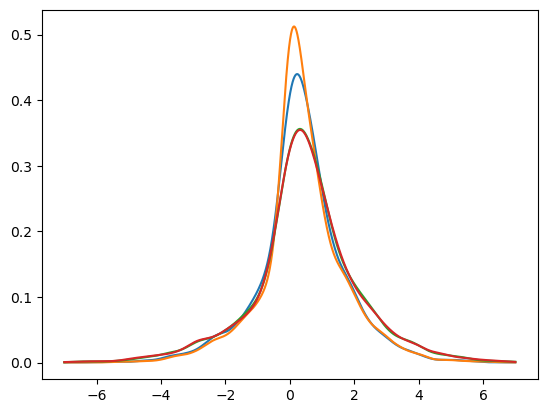

In [122]:
plt.plot(x_grid, sst_true_pdf)
plt.plot(x_grid, sst_pred_unet_pdf)
plt.plot(x_grid, sst_pred_genda_mean_pdf)
plt.plot(x_grid, sst_pred_genda_member_pdf)


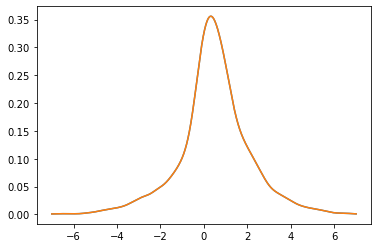

In [33]:
plt.plot(x_grid, sst_true_pdf)
# plt.plot(x_grid, sst_pred_unet_pdf)
plt.plot(x_grid, sst_pred_genda_mean_pdf)
# plt.plot(x_grid, sst_pred_genda_member_pdf)


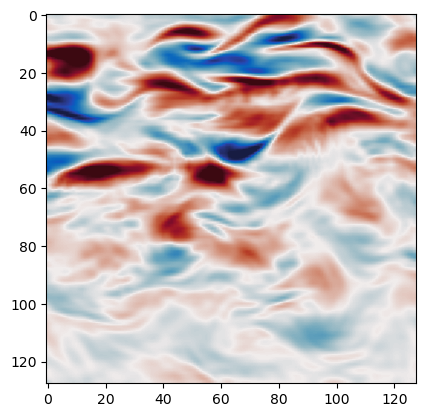

In [140]:
plt.imshow(np.flipud(u_genda_mean[187,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

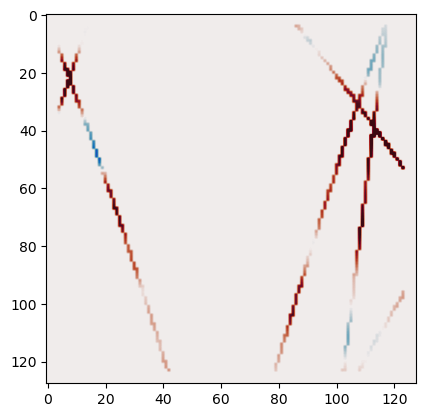

In [112]:
plt.imshow(np.flipud(ssh_true[187,] * ssh_mask[187,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

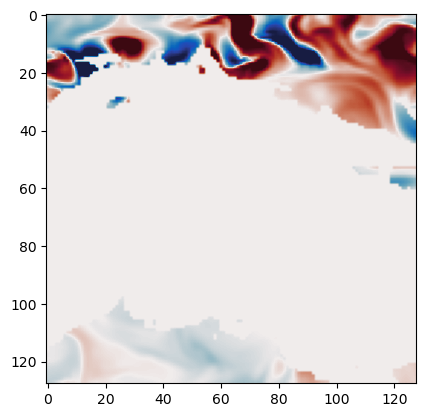

In [136]:
t = 81
plt.imshow(np.flipud(sst_true[t,] * sst_mask[t,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

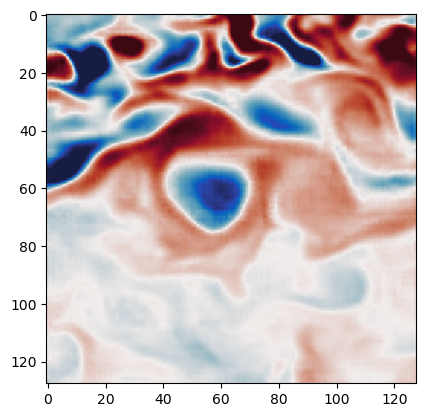

In [137]:
plt.imshow(np.flipud(sst_unet[t,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

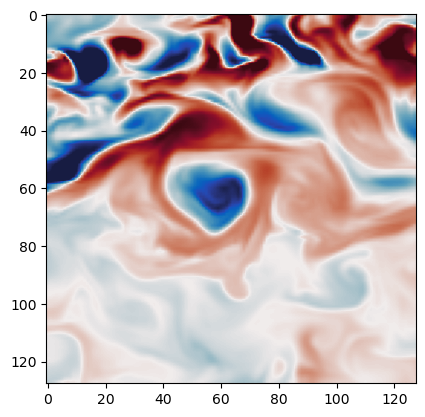

In [138]:
plt.imshow(np.flipud(sst_true[t,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

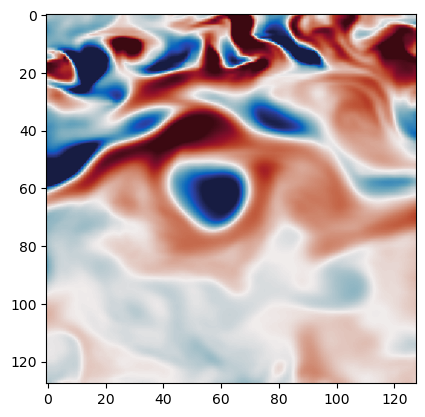

In [139]:
plt.imshow(np.flipud(sst_genda_mean[t,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

In [180]:
ds_obs = xr.open_dataset('input_data/OSE_L3_products.nc')
ds_oi = xr.open_dataset('input_data/OSE_L4_products_v2.nc')
ds_oi = ds_oi.transpose('time','latitude','longitude')
ds_obs = ds_obs.transpose('time','latitude','longitude')



In [181]:
preds = np.zeros((365,5,128,128))
inputs = np.zeros((365,7,128,128))

for t in range(365):
    if t % 10 == 0:
        print(t)

    ssh_obs = torch.from_numpy(ds_obs['ssh'].isel(time=t).values)
    ssh_obs_err = torch.from_numpy(ds_obs['ssh_error'].isel(time=t).values)
    sst_obs = torch.from_numpy(ds_obs['sst'].isel(time=t).values)
    sst_obs_err = torch.from_numpy(ds_obs['sst_error'].isel(time=t).values)
    # ssh_obs = torch.from_numpy(ssh_obs[~np.isnan(ssh_obs)])
    # sst_obs = torch.from_numpy(sst_obs[~np.isnan(sst_obs)])
    uas_obs = torch.from_numpy(test_dataset.ds_model['uas'].isel(time=t).values)
    vas_obs = torch.from_numpy(test_dataset.ds_model['vas'].isel(time=t).values)
    data_obs = torch.stack((ssh_obs, sst_obs, torch.zeros((128,128)), torch.zeros((128,128)), torch.zeros((128,128)), uas_obs, vas_obs), axis=0)
    data_obs_err = torch.stack((ssh_obs_err, sst_obs_err, torch.zeros((128,128)), torch.zeros((128,128)), torch.zeros((128,128)), torch.zeros((128,128)), torch.zeros((128,128))), axis=0)
    
    total_mask = np.stack((~np.isnan(ssh_obs.numpy()), ~np.isnan(sst_obs.numpy()), np.zeros((128,128)), np.zeros((128,128)), np.zeros((128,128)), np.ones((128,128)), np.ones((128,128)))).astype('bool')
    
    oi_ground_truth = torch.from_numpy(np.expand_dims(np.stack((ds_oi['ssh'].isel(time = t),
                               ds_oi['sst'].isel(time = t),
                               ds_oi['sss'].isel(time = t)), axis = 0), axis = 0))
    
    oi_ground_truth_err = torch.from_numpy(np.expand_dims(np.stack((ds_oi['ssh_error'].isel(time = t),
                               ds_oi['sst_error'].isel(time = t),
                               ds_oi['sss_error'].isel(time = t)), axis = 0), axis = 0))
    
    oi_mask = np.stack((~np.isnan(ds_oi['ssh'].isel(time = t)), ~np.isnan(ds_oi['sst'].isel(time = t)), ~np.isnan(ds_oi['sss'].isel(time = t))), axis = 0)
    
    x = torch.stack((ssh_obs, sst_obs, uas_obs, vas_obs, oi_ground_truth[0,0,], oi_ground_truth[0,1,], oi_ground_truth[0,2,]))
    x = torch.nan_to_num(x, nan=0)
    x = x.expand(1,7,128,128).float()

    pred = model(x.to(device)).detach().cpu().numpy()
    preds[t,] = pred[0,]
    inputs[t,] = x[0,].numpy()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


In [182]:
x = torch.stack((ssh_obs, sst_obs, uas_obs, vas_obs, oi_ground_truth[0,0,], oi_ground_truth[0,1,], oi_ground_truth[0,2,]))
x = torch.nan_to_num(x, nan=0)
x = x.expand(1,7,128,128).float()

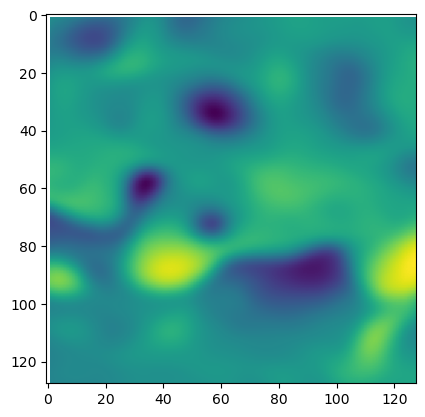

In [183]:
plt.imshow(oi_ground_truth[0,0,])

In [153]:
model.eval()
pred = model(x.to(device)).detach().cpu().numpy()

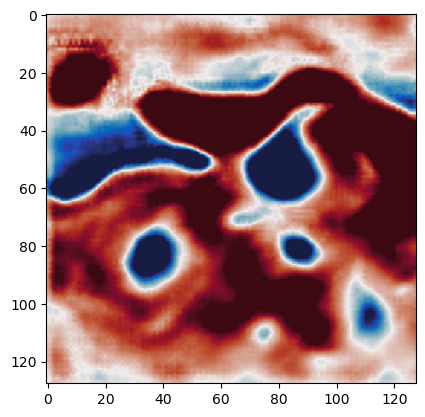

In [184]:
plt.imshow(np.flipud(preds[187,0,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

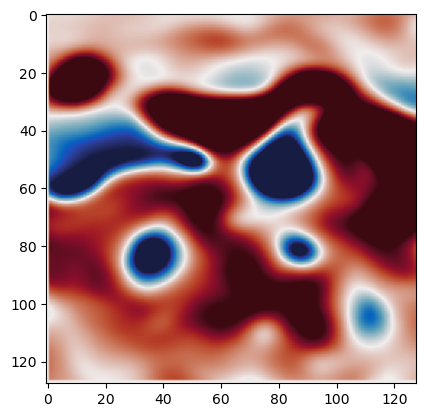

In [185]:
plt.imshow(np.flipud(inputs[187,4,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

In [ ]:
plt.imshow(np.flipud(preds[100,0,]), cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

In [192]:
ds_m = ds_m.sel(longitude = slice(lon_min_NN, lon_max_NN-NN_res), latitude = slice(lat_min_NN, lat_max_NN-NN_res))
ds_clim = ds_clim.sel(longitude = slice(lon_min_NN, lon_max_NN-NN_res), latitude = slice(lat_min_NN, lat_max_NN-NN_res))


In [212]:
ds_m

<xarray.Dataset> Size: 1MB
Dimensions:              (depth: 1, latitude: 128, longitude: 128)
Coordinates:
  * depth                (depth) float32 4B 0.494
  * latitude             (latitude) float32 512B 32.67 32.75 ... 43.17 43.25
  * longitude            (longitude) float32 512B -65.33 -65.25 ... -54.75
Data variables: (12/17)
    so                   (depth, latitude, longitude) float32 66kB ...
    thetao               (depth, latitude, longitude) float32 66kB ...
    uo                   (depth, latitude, longitude) float32 66kB ...
    vo                   (depth, latitude, longitude) float32 66kB ...
    zos                  (latitude, longitude) float32 66kB 0.3025 ... -0.4957
    uas                  (latitude, longitude) float32 66kB ...
    ...                   ...
    u_ageo_smoothed_15m  (latitude, longitude) float32 66kB ...
    v_ageo_smoothed_15m  (latitude, longitude) float32 66kB ...
    tau_x                (latitude, longitude) float32 66kB ...
    tau_y                (latitude, longitude) float32 66kB ...
    u_ageo_eddy          (latitude, longitude) float32 66kB ...
    v_ageo_eddy          (latitude, longitude) float32 66kB ...

In [234]:
lon_grid = test_dataset.ds_model['longitude'].values
lat_grid = test_dataset.ds_model['latitude'].values
time_grid = test_dataset.ds_model['time'].values


da_ssh = xr.DataArray(data = preds[:,0,]*var_stds['zos'],
                     dims=["time","latitude", "longitude"],
                           coords=dict(time=("time", time_grid), longitude=("longitude", lon_grid), latitude=("latitude", lat_grid)))

da_sst = xr.DataArray(data = preds[:,1,]*var_stds['thetao'],
                     dims=["time","latitude", "longitude"],
                           coords=dict(time=("time", time_grid), longitude=("longitude", lon_grid), latitude=("latitude", lat_grid)))
da_sst = da_sst.groupby('time.month') + ds_clim['thetao']

da_sss = xr.DataArray(data = preds[:,2,]*var_stds['so'],
                     dims=["time","latitude", "longitude"],
                           coords=dict(time=("time", time_grid), longitude=("longitude", lon_grid), latitude=("latitude", lat_grid)))
da_sss = da_sst.groupby('time.month') + ds_clim['so']

da_u = xr.DataArray(data = preds[:,3,]*var_stds['u_ageo_eddy'] + ds_m['u_ageo_eddy'].values,
                     dims=["time","latitude", "longitude"],
                           coords=dict(time=("time", time_grid), longitude=("longitude", lon_grid), latitude=("latitude", lat_grid)))

da_v = xr.DataArray(data = preds[:,4,]*var_stds['v_ageo_eddy'] + ds_m['v_ageo_eddy'].values,
                     dims=["time","latitude", "longitude"],
                           coords=dict(time=("time", time_grid), longitude=("longitude", lon_grid), latitude=("latitude", lat_grid)))

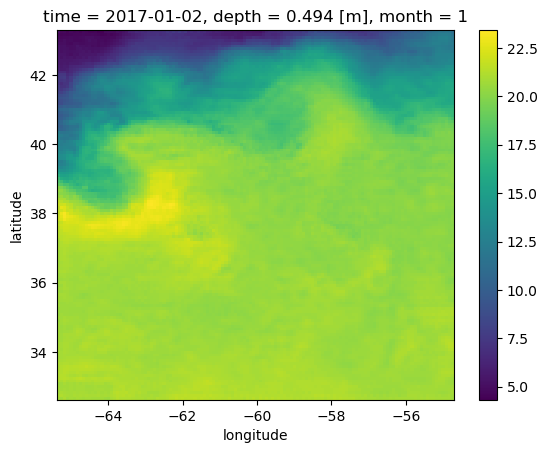

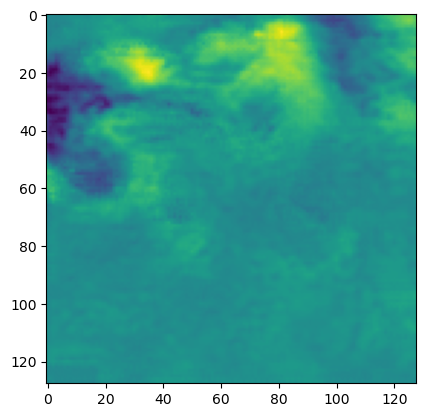

In [210]:
plt.imshow(np.flipud(preds[1,1,]))

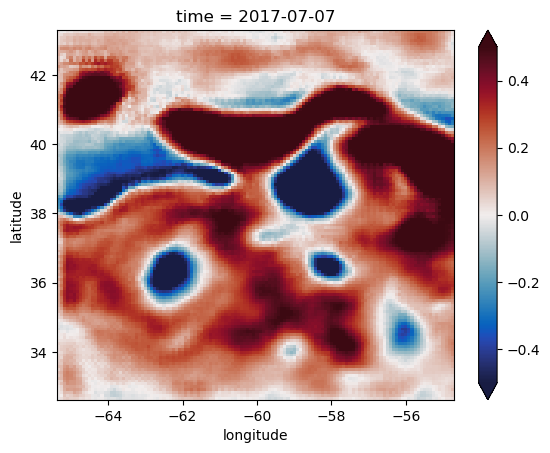

In [203]:
da_ssh.isel(time = 187).plot(cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5)

In [235]:
ds_unet = xr.Dataset({'sla':da_ssh, 'sst':da_sst, 'sss':da_sss, 'u_ageo_eddy':da_u, 'v_ageo_eddy':da_v}) 

In [236]:
ds_unet = ds_unet.isel(depth=0,drop=True)
ds_unet = ds_unet.drop('month')
ds_unet

/var/tmp/pbs.186252.pbspl4.nas.nasa.gov/ipykernel_23867/2420487566.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_unet = ds_unet.drop('month')


<xarray.Dataset> Size: 239MB
Dimensions:      (time: 365, longitude: 128, latitude: 128)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2017-01-01 2017-01-02 ... 2017-12-31
  * longitude    (longitude) float32 512B -65.33 -65.25 -65.17 ... -54.83 -54.75
  * latitude     (latitude) float32 512B 32.67 32.75 32.83 ... 43.08 43.17 43.25
Data variables:
    sla          (time, latitude, longitude) float64 48MB 0.01399 ... 0.153
    sst          (time, latitude, longitude) float64 48MB 21.18 20.71 ... 8.633
    sss          (time, latitude, longitude) float64 48MB 57.77 57.31 ... 42.5
    u_ageo_eddy  (time, latitude, longitude) float64 48MB -0.01963 ... -0.01242
    v_ageo_eddy  (time, latitude, longitude) float64 48MB 0.01393 ... 0.00973

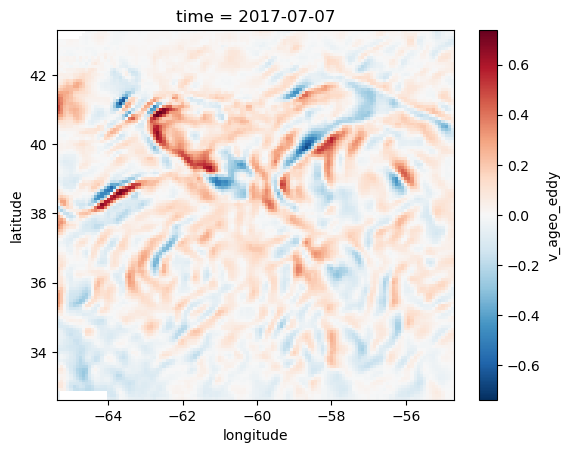

In [238]:
ds_unet['v_ageo_eddy'].isel(time = 187).plot()

In [239]:
ds_unet.to_netcdf('UNet_regression_OSE_preds.nc')